<h2>Model Exploration</h2>

In [101]:
import time

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV


#learning
import tensorflow as tf
from tensorflow.python.keras import layers

from fairlearn.metrics import MetricFrame, make_derived_metric
from sklearn.metrics import precision_score
from fairlearn.metrics import selection_rate, false_positive_rate, false_negative_rate
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import lightgbm as lgb
import xgboost as xgb


# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [2]:
# description
description = pd.read_csv('data/WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('data/training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
description_dict

The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization'.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [3]:
new_df = df.dropna(subset=['ethnicity'])

In [4]:
num_rows = len(new_df) #used later
num_rows

90318

In [5]:
ethcounts = new_df['ethnicity'].value_counts() #ethcounts is used later
display(ethcounts)
ethcounts["Caucasian"]

Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64

70684

In [6]:
PY1 = len(new_df.loc[(df['hospital_death'] == 1)])/num_rows
print(PY1)
PY0 = len(new_df.loc[(df['hospital_death'] == 0)])/num_rows
print(PY0)
print(PY1 + PY0)

0.0864722425208707
0.9135277574791293
1.0


In [7]:
# display(new_df['ethnicity'].value_counts())

ethniciies = new_df['ethnicity'].unique()  #get array of ethnicities

prob_obv_y1 = []
prob_obv_y0 = []

for ethnicity in ethniciies:
#     print(ethnicity)
#     print(new_df['ethnicity'].value_counts()[ethnicity])
#     num_eth_tot = new_df['ethnicity'].value_counts()[ethnicity]
    num_tot = num_rows
    num_eth_dead = len(new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 1)])
    num_eth_alive = len(new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 0)])
    obv_prop_Y1_eth = num_eth_dead/num_tot
    obv_prop_Y0_eth = num_eth_alive/num_tot
#     print(obv_prop_Y1_eth)
#     print(obv_prop_Y0_eth)
#     print(obv_prop_Y0_eth+ obv_prop_Y1_eth)
    prob_obv_y1.append(obv_prop_Y1_eth)
    prob_obv_y0.append(obv_prop_Y0_eth)
    
# print(prob_obv_y1)   
# print(prob_obv_y0)

probs = {
  "observed y=1": prob_obv_y1,
  "observed y=0": prob_obv_y0
}

df_probs = pd.DataFrame(probs, index = ethniciies)
display(df_probs)
df_probs["observed y=1"]['Caucasian']

,observed y=1,observed y=0
Caucasian,0.068292,0.714321
Hispanic,0.004163,0.037866
African American,0.008304,0.097400
Asian,0.001030,0.011471
Native American,0.000775,0.007950
Other/Unknown,0.003908,0.044520


0.06829203481033681

In [8]:
Information = {'ethnicity': ['Caucasian', 'Caucasian', 'Hispanic', 'Hispanic', 'African American', 'African American', 'Asian', 'Asian',
       'Native American', 'Native American', 'Other/Unknown', 'Other/Unknown'],
               'class': [0, 1, 0, 1,0, 1,0, 1,0, 1,0, 1],                
               'weights': [0]*12}

weights_df = pd.DataFrame(Information)

# weights_df.loc[weights_df['ethnicity'] == "Caucasian" & weights_df['class'] ==0]

# weights_df.loc[(weights_df['ethnicity'] == "Caucasian") & (weights_df['class'] == 1)]['weights']

weights_df = weights_df.set_index(["ethnicity", "class"]) #, "class"

weights_df.loc['Caucasian',1]#[1]

weights_df#['Caucasian']

for ethnicity in ethniciies:
    for i in range(2):
        if i==1:
#             print(ethnicity)
#             print(i)
            P_exp = PY1 * (ethcounts[ethnicity]/num_rows)
            P_obs = df_probs["observed y=1"][ethnicity]
#             print(P_exp)
        else:
#             print(ethnicity)
#             print(i)
            P_exp = PY0 * (ethcounts[ethnicity]/num_rows)
            P_obs = df_probs["observed y=0"][ethnicity]
        weight = P_exp/P_obs
        weights_df.loc[ethnicity,i] = weight
        
display(weights_df)
# weights_df.loc['Caucasian', 0]['weights']

weights
ethnicity        class          
Caucasian        0      1.000865
                 1      0.990954
Hispanic         0      1.013962
                 1      0.873002
African American 0      0.991412
                 1      1.100734
Asian            0      0.995534
                 1      1.049754
Native American  0      1.002590
                 1      0.973430
Other/Unknown    0      0.993726
                 1      1.071472

In [9]:
Information_sampledf = {'ethnicity': ['Caucasian', 'Caucasian', 'Hispanic', 'Hispanic', 'African American', 'African American', 'Asian', 'Asian',
       'Native American', 'Native American', 'Other/Unknown', 'Other/Unknown'],
               'class': [0, 1, 0, 1,0, 1,0, 1,0, 1,0, 1],                
               'number to be sampled': [0]*12}

sample_numbers_df = pd.DataFrame(Information_sampledf)

sample_numbers_df = sample_numbers_df.set_index(["ethnicity", "class"]) 

for ethnicity in ethniciies:
    for i in range(2):
        if i==1:
            sample_num = round(weights_df.loc[ethnicity, 1]['weights'] \
                            * len(new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 1)]))
        else:
            sample_num = round(weights_df.loc[ethnicity, 0]['weights'] * \
                               len(new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 0)]))
        sample_numbers_df.loc[ethnicity,i] = sample_num
        
display(sample_numbers_df)
sample_numbers_df.loc['Caucasian', 0]['number to be sampled']

number to be sampled
ethnicity        class                      
Caucasian        0                     64572
                 1                      6112
Hispanic         0                      3468
                 1                       328
African American 0                      8721
                 1                       826
Asian            0                      1031
                 1                        98
Native American  0                       720
                 1                        68
Other/Unknown    0                      3996
                 1                       378

64572

In [10]:
final_df = pd.DataFrame()

for ethnicity in ethniciies:
    for i in range(2):
        if i==1:
#             df['num_legs'].sample(n=3, random_state=1)
            sample_num = sample_numbers_df.loc[ethnicity, 1]['number to be sampled']
            #if we need to oversample
            if sample_num > len(new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 1)]):
                temp_df = new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 1)]\
                        .sample(n=sample_numbers_df.loc[ethnicity, 1]['number to be sampled'], replace=True, random_state=1)
            else: #undersample
                temp_df = new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 1)]\
                    .sample(n=sample_numbers_df.loc[ethnicity, 1]['number to be sampled'], random_state=1)
            final_df = pd.concat([final_df, temp_df])
        else:
            sample_num = sample_numbers_df.loc[ethnicity, 0]['number to be sampled']
            #if we need to oversample
            if sample_num > len(new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 0)]):
                temp_df = new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 0)]\
                        .sample(n=sample_numbers_df.loc[ethnicity, 0]['number to be sampled'], replace=True, random_state=1)
            else: #undersample
                temp_df = new_df.loc[(new_df['ethnicity'] == ethnicity) & (new_df['hospital_death'] == 0)]\
                    .sample(n=sample_numbers_df.loc[ethnicity, 0]['number to be sampled'], random_state=1)
            final_df = pd.concat([final_df, temp_df])
        
final_df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
89248,35599,39339,35,0,34.0,20.173155,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
47499,24362,82815,21,0,66.0,22.855304,0,Caucasian,F,167.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
18868,126611,64860,161,0,40.0,27.871313,0,Caucasian,F,157.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
6599,21292,30734,118,0,51.0,16.304874,0,Caucasian,F,167.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Neurological,Neurologic
46834,115657,25821,99,0,52.0,24.308230,0,Caucasian,M,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [11]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus valsplit
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [12]:
start_time = time.time()

# save features
X = final_df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem', 'bmi'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = final_df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = final_df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

# """MISSING VALUES"""
# # drop columns with many missing values
# missing = X_train.isna().sum() > max_missing * len(X_train)
# missing = missing[missing].index
# X_train = X_train.drop(missing, axis=1)
# X_val = X_val.drop(missing, axis=1)
# X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="median")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

c:\Users\20200642\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A24C382880>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A24C382FD0>)])

Time: 3.50s
Train set: 72254 rows, 216 columns
Validation set: 9032 rows, 216 columns
Test set: 9032 rows, 216 columns


In [ ]:
# modelLight = lgb.LGBMClassifier(num_leaves=100)
# modelLight.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_metric='auc')

# cross_validation(modelLight, X_train, y_train)

Median Strategy

In [71]:
# start_time = time.time()

# # save features
# X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
#                     'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
#                     'apache_2_bodysystem', 'bmi'], # drop because of similarity with apache_3j_bodysystem
#                    axis=1)
# # save target variable
# y = df['hospital_death'].copy()
# # save APACHE scores for later evaluation on train / test / validation data
# y_apache = df['apache_4a_hospital_death_prob'].copy()

# """ SPLIT DATA SET """
# # split the dataset into train and test+validation set
# (
#     X_train,
#     X_test,
#     y_train,
#     y_test,
#     y_apache_train,
#     y_apache_test,
#     ) = train_test_split(X, y, y_apache, 
#                          test_size=test_size, # used for testing and validation
#                          random_state=random_state # for reproducibility
#                         ) 
# # split the test set into test + validation set
# (
#     X_val,
#     X_test,
#     y_val,
#     y_test,
#     y_apache_val,
#     y_apache_test,
#     ) = train_test_split(X_test, y_test, y_apache_test, 
#                          test_size=val_size, # used for testing and validation
#                          random_state=random_state # for reproducibility
#                         ) 

# # """MISSING VALUES"""
# # # drop columns with many missing values
# # missing = X_train.isna().sum() > max_missing * len(X_train)
# # missing = missing[missing].index
# # X_train = X_train.drop(missing, axis=1)
# # X_val = X_val.drop(missing, axis=1)
# # X_test = X_test.drop(missing, axis=1)

# """FURTHER PROCESSING PIPELINE"""
# # define pre-processing steps for numerical features
# num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
#                                   ("imputer", SimpleImputer(strategy="median")),
#                                  ])
# # define preprocessing steps for categorical features
# cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"))])
# # create preprocessing pipeline
# prep_pipeline = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
#         ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
#     ])
# # pipeline
# prep_pipeline.fit(X_train, y_train)
# display(prep_pipeline) # disply preprocessing pipeline

# # transform data sets
# X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
# X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
# X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
# """PRINT STATS"""
# print("Time: %.2fs" % (time.time() - start_time))
# print("Train set: %s rows, %s columns" % X_train.shape)
# print("Validation set: %s rows, %s columns" % X_val.shape)
# print("Test set: %s rows, %s columns" % X_test.shape)

c:\Users\20200642\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023D9D2E91F0>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023D9D2E9040>)])

Time: 3.89s
Train set: 73370 rows, 217 columns
Validation set: 9171 rows, 217 columns
Test set: 9172 rows, 217 columns


In [ ]:
# modelLight = lgb.LGBMClassifier(num_leaves=100)
# modelLight.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_metric='auc')

# # cross_validation(modelLight, X_train, y_train)

KNNImputer (Dont run right now has extremely long runtime)

In [ ]:
# start_time = time.time()

# # save features
# X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
#                     'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
#                     'apache_2_bodysystem', 'bmi'], # drop because of similarity with apache_3j_bodysystem
#                    axis=1)
# # save target variable
# y = df['hospital_death'].copy()
# # save APACHE scores for later evaluation on train / test / validation data
# y_apache = df['apache_4a_hospital_death_prob'].copy()

# """ SPLIT DATA SET """
# # split the dataset into train and test+validation set
# (
#     X_train,
#     X_test,
#     y_train,
#     y_test,
#     y_apache_train,
#     y_apache_test,
#     ) = train_test_split(X, y, y_apache, 
#                          test_size=test_size, # used for testing and validation
#                          random_state=random_state # for reproducibility
#                         ) 
# # split the test set into test + validation set
# (
#     X_val,
#     X_test,
#     y_val,
#     y_test,
#     y_apache_val,
#     y_apache_test,
#     ) = train_test_split(X_test, y_test, y_apache_test, 
#                          test_size=val_size, # used for testing and validation
#                          random_state=random_state # for reproducibility
#                         ) 

# # """MISSING VALUES"""
# # # drop columns with many missing values
# # missing = X_train.isna().sum() > max_missing * len(X_train)
# # missing = missing[missing].index
# # X_train = X_train.drop(missing, axis=1)
# # X_val = X_val.drop(missing, axis=1)
# # X_test = X_test.drop(missing, axis=1)

# """FURTHER PROCESSING PIPELINE"""
# # define pre-processing steps for numerical features
# num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
#                                   ("imputer", KNNImputer()),
#                                  ])
# # define preprocessing steps for categorical features
# cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"))])
# # create preprocessing pipeline
# prep_pipeline = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
#         ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
#     ])
# # pipeline
# prep_pipeline.fit(X_train, y_train)
# display(prep_pipeline) # disply preprocessing pipeline

# # transform data sets
# X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
# X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
# X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
# """PRINT STATS"""
# print("Time: %.2fs" % (time.time() - start_time))
# print("Train set: %s rows, %s columns" % X_train.shape)
# print("Validation set: %s rows, %s columns" % X_val.shape)
# print("Test set: %s rows, %s columns" % X_test.shape)

In [ ]:
# cross_validation(modelLight, X_train, y_train)

<h2> Model Exploration with different Libraries and models </h2>

In this section I explore multiple different models in order to learn more about model development for this certain dataset. The possible steps that might be worthwhile to look into can include feature-selection based on correlation (however there are many categorical features)


In [ ]:
# #checking feature importance from boruta
# X_boruta = X_train.values
# Y_boruta = y_train.values

# # define random forest classifier, with utilising all cores and
# # sampling in proportion to y labels
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# # define Boruta feature selection method
# feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
# # find all relevant features - 5 features should be selected
# feat_selector.fit(X_boruta, Y_boruta)
# # check selected features - first 5 features are selected
# feat_selector.support_
# # check ranking of features
# feat_selector.ranking_
# # call transform() on X to filter it down to selected features
# X_filtered = feat_selector.transform(X_boruta)

In [ ]:
# X_train.columns[feat_selector.support_]

In [13]:
# K-Fold Cross-Validation
#taken from https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/
from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'roc_auc', 'f1', 'recall']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training AUC scores": results['train_roc_auc'],
              "Mean Training AUC score": results['train_roc_auc'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation AUC Scores": results['test_roc_auc'],
              "Mean Validation AUC score": results['test_roc_auc'].mean(),
              "Validation f1 Scores": results['test_f1'],
              "Mean Validation f1 score": results['test_f1'].mean(),
              "Validation recall Scores": results['test_recall'],
              "Mean Validation recall score": results['test_recall'].mean()
              }

In [168]:
def pred_thresh(threshold, y_prob):
    predictions = np.where(y_prob > threshold, 1, 0)
    return predictions

In [15]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_X, oversampled_Y = sm.fit_resample(X_train, y_train)

<h2>MODEL EXPLORATION AND SELECTION PIPELINE</h2>

In [120]:
eval_set = [(X_val, y_val)]

In [121]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sgdclf = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3))


In [122]:
cross_validation(sgdclf, oversampled_X, oversampled_Y)

{'Training Accuracy scores': array([0.80621842, 0.8034366 , 0.80338929, 0.80380747, 0.80366554]),
 'Mean Training Accuracy': 80.41034621936494,
 'Training AUC scores': array([0.88802411, 0.88561331, 0.88529684, 0.8876958 , 0.88444146]),
 'Mean Training AUC score': 0.8862143029274234,
 'Validation Accuracy scores': array([0.80383771, 0.80701688, 0.80516236, 0.80031036, 0.80099164]),
 'Mean Validation Accuracy': 80.34637900385636,
 'Validation AUC Scores': array([0.88557189, 0.8876151 , 0.88583731, 0.88453569, 0.88244302]),
 'Mean Validation AUC score': 0.8852006034586823,
 'Validation f1 Scores': array([0.8021227 , 0.80483791, 0.8041692 , 0.7950272 , 0.80024314]),
 'Mean Validation f1 score': 0.801280030401762,
 'Validation recall Scores': array([0.79517069, 0.79585194, 0.80009083, 0.77456472, 0.79721444]),
 'Mean Validation recall score': 0.7925785264510437}

In [123]:
sgdclf.fit(oversampled_X, oversampled_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='log_loss'))])

In [124]:
y_pred_sgd = sgdclf.predict(X_val)

In [125]:
y_sgd_proba = sgdclf.predict_proba(X_val)

In [126]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

0.2276843467011643
0.8666207095102023


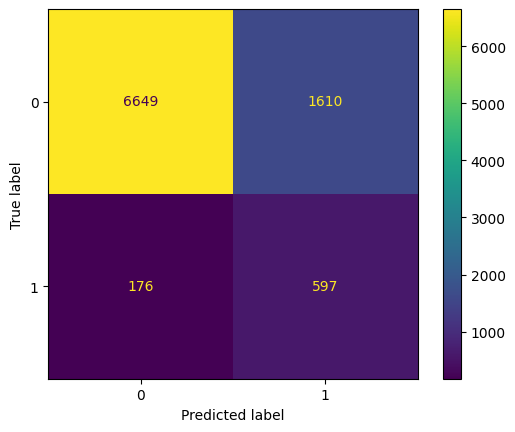

In [127]:

conf_mat = confusion_matrix(y_val, y_pred_sgd)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)
print(roc_auc_score(y_val, y_sgd_proba[:,1]))

In [170]:
from sklearn.metrics import roc_curve
y_pred_sgd_prob = sgdclf.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_sgd_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold_sgd = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.560303, G-Mean=0.793


In [171]:
sgd_pred_new = pred_thresh(thresholds[ix], y_pred_sgd_prob)

0.25097024579560157
0.8666207095102023


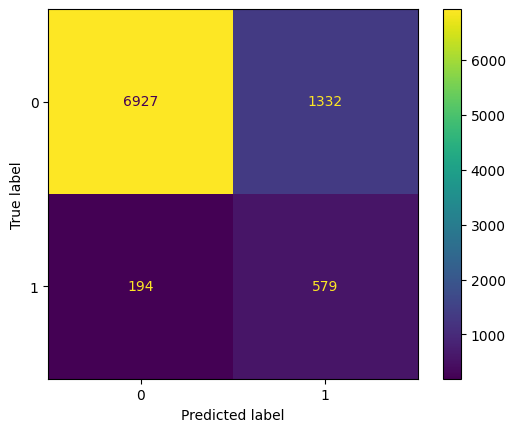

In [172]:

conf_mat = confusion_matrix(y_val, sgd_pred_new)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)
print(roc_auc_score(y_val, y_sgd_proba[:,1]))

In [131]:
eval_set = [(X_val, y_val)]

In [59]:
#run with gradeint based trees
modelLight = lgb.LGBMClassifier()
# modelLight.fit(X_filtered, y_train, eval_set=[(X_val_filtered, y_val), (X_filtered, y_train)], eval_metric='auc')

parameters = {'num_leaves' : [10, 20, 50, 100, 200, 500], 'boosting_type':('gbdt', 'dart')}
clf = GridSearchCV(modelLight, parameters)
clf.fit(oversampled_X, oversampled_Y)


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'boosting_type': ('gbdt', 'dart'),
                         'num_leaves': [10, 20, 50, 100, 200, 500]})

In [60]:
clf.best_estimator_

LGBMClassifier(boosting_type='dart', num_leaves=500)

In [132]:
modelLightHP = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=500, class_weight='balanced')


In [133]:
cross_validation(modelLightHP, oversampled_X, oversampled_Y)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training AUC scores': array([1., 1., 1., 1., 1.]),
 'Mean Training AUC score': 1.0,
 'Validation Accuracy scores': array([0.80750889, 0.99303611, 0.99212777, 0.99326293, 0.9929223 ]),
 'Mean Validation Accuracy': 95.57716008268218,
 'Validation AUC Scores': array([0.96837685, 0.99995722, 0.99996808, 0.99995495, 0.99993922]),
 'Mean Validation AUC score': 0.9936392645065129,
 'Validation f1 Scores': array([0.76191368, 0.99308167, 0.99218809, 0.99330374, 0.99297019]),
 'Mean Validation f1 score': 0.9466914720412177,
 'Validation recall Scores': array([0.61600182, 0.99962153, 0.99984861, 0.9993944 , 0.99969722]),
 'Mean Validation recall score': 0.9229127150768026}

In [134]:
modelLightHP.fit(oversampled_X, oversampled_Y)

LGBMClassifier(class_weight='balanced', num_leaves=500)

0.5834411384217335


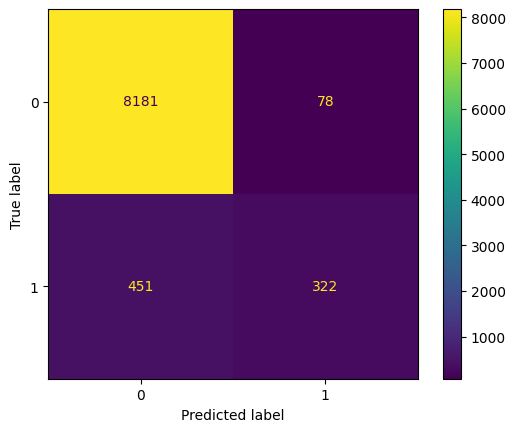

In [135]:
y_pred_lgb = modelLightHP.predict(X_val)

conf_mat = confusion_matrix(y_val, y_pred_lgb)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)

In [136]:
from sklearn.metrics import roc_curve
y_pred_lgb_prob = modelLightHP.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_lgb_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold_lgb = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.027177, G-Mean=0.858


In [137]:
lgb_pred_new = pred_thresh(thresholds[ix], y_pred_lgb_prob)

0.16817593790426907
0.9230328841154429


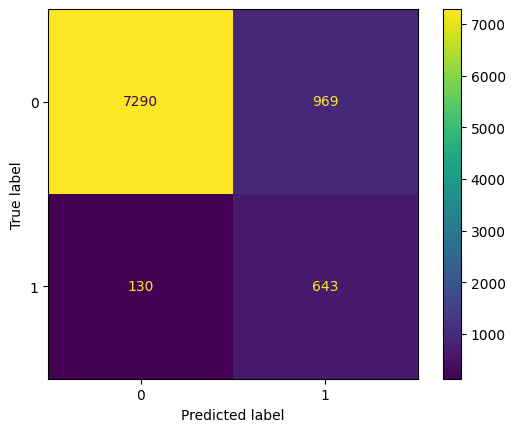

In [138]:

conf_mat = confusion_matrix(y_val, lgb_pred_new)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)
print(roc_auc_score(y_val, y_pred_lgb_prob))

Implementation in XGboost (Random Forests)

In [88]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
parameters = {'max_depth' : [2, 6, 10]}
clfxgb = GridSearchCV(xgb_model, parameters)
clfxgb.fit(oversampled_X, oversampled_Y)



KeyboardInterrupt: 

In [ ]:
clfxgb.best_estimator_

In [139]:
xgbHP = xgb.XGBClassifier(objective="binary:logistic", max_depth=10, booster='gbtree', scale_pos_weight=10.5, eval_metric='auc')

In [91]:
cross_validation(xgbHP, oversampled_X, oversampled_Y)

{'Training Accuracy scores': array([1.        , 0.99984861, 0.99990538, 0.99990538, 0.99995269]),
 'Mean Training Accuracy': 99.99224119408977,
 'Training AUC scores': array([1., 1., 1., 1., 1.]),
 'Mean Training AUC score': 0.9999999974215757,
 'Validation Accuracy scores': array([0.80546514, 0.98319582, 0.98130346, 0.98357367, 0.98137845]),
 'Mean Validation Accuracy': 94.69833090009946,
 'Validation AUC Scores': array([0.9466534 , 0.99994876, 0.99992283, 0.99995925, 0.99992292]),
 'Mean Validation AUC score': 0.9892814328370843,
 'Validation f1 Scores': array([0.75882132, 0.98347354, 0.9816466 , 0.98383853, 0.98171819]),
 'Mean Validation f1 score': 0.9378996375638857,
 'Validation recall Scores': array([0.6120657 , 1.        , 1.        , 1.        , 0.99992431]),
 'Mean Validation recall score': 0.9223980016652789}

In [140]:
xgbHP.fit(oversampled_X, oversampled_Y, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.80752
[1]	validation_0-auc:0.83097
[2]	validation_0-auc:0.83936
[3]	validation_0-auc:0.84531
[4]	validation_0-auc:0.85159
[5]	validation_0-auc:0.85890
[6]	validation_0-auc:0.86595
[7]	validation_0-auc:0.87152
[8]	validation_0-auc:0.87205
[9]	validation_0-auc:0.87363
[10]	validation_0-auc:0.87623
[11]	validation_0-auc:0.87982
[12]	validation_0-auc:0.88135
[13]	validation_0-auc:0.88315
[14]	validation_0-auc:0.88322
[15]	validation_0-auc:0.88449
[16]	validation_0-auc:0.88576
[17]	validation_0-auc:0.88644
[18]	validation_0-auc:0.88705
[19]	validation_0-auc:0.88810
[20]	validation_0-auc:0.88883
[21]	validation_0-auc:0.88922
[22]	validation_0-auc:0.89002
[23]	validation_0-auc:0.88997
[24]	validation_0-auc:0.88982
[25]	validation_0-auc:0.89067
[26]	validation_0-auc:0.89144
[27]	validation_0-auc:0.89206
[28]	validation_0-auc:0.89230
[29]	validation_0-auc:0.89370
[30]	validation_0-auc:0.89489
[31]	validation_0-auc:0.89504
[32]	validation_0-auc:0.89539
[33]	validation_0-au

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

0.45278137128072443


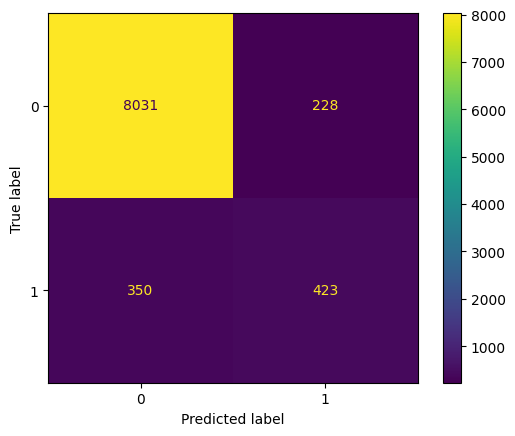

In [141]:
y_pred_xgb = xgbHP.predict(X_val)

conf_mat = confusion_matrix(y_val, y_pred_xgb)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)

In [142]:
from sklearn.metrics import roc_curve
y_pred_xgb_prob = xgbHP.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold_xgb = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (threshold_xgb, gmeans[ix]))

Best Threshold=0.073103, G-Mean=0.840


In [143]:
xgb_pred_new = pred_thresh(thresholds[ix], y_pred_xgb_prob)

0.18628719275549807
0.9092693892914187


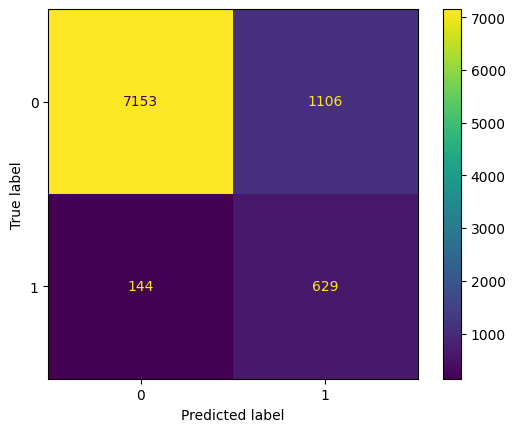

In [144]:

conf_mat = confusion_matrix(y_val, xgb_pred_new)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)
print(roc_auc_score(y_val, y_pred_xgb_prob))

RF SKlearn


In [53]:
from sklearn.ensemble import RandomForestClassifier


#done with no tuning of the hyperparameters which in practice is quite 
forestSK = RandomForestClassifier()



In [ ]:
parameters = {'n_estimators' : [100, 200], 'class_weight' : [None, "balanced"]}
clf = GridSearchCV(forestSK, parameters)
clf.fit(oversampled_X, oversampled_Y)

In [ ]:
clf.best_estimator_

In [145]:

forestSKHP = RandomForestClassifier(n_estimators=200, class_weight='balanced')


In [59]:
cross_validation(forestSK, oversampled_X, oversampled_Y)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training AUC scores': array([1., 1., 1., 1., 1.]),
 'Mean Training AUC score': 1.0,
 'Validation Accuracy scores': array([0.8865718 , 0.98383922, 0.98467186, 0.98357367, 0.98330873]),
 'Mean Validation Accuracy': 96.43930579244883,
 'Validation AUC Scores': array([0.98379389, 0.99933132, 0.99931687, 0.99927362, 0.999174  ]),
 'Mean Validation AUC score': 0.9961779406955664,
 'Validation f1 Scores': array([0.87377332, 0.98402843, 0.98485925, 0.98377085, 0.98350724]),
 'Mean Validation f1 score': 0.9619878161740957,
 'Validation recall Scores': array([0.78517902, 0.99568541, 0.99704791, 0.99576079, 0.99530694]),
 'Mean Validation recall score': 0.95379601484804}

In [146]:

forestSKHP.fit(oversampled_X, oversampled_Y)

RandomForestClassifier(class_weight='balanced', n_estimators=200)

0.5265200517464425


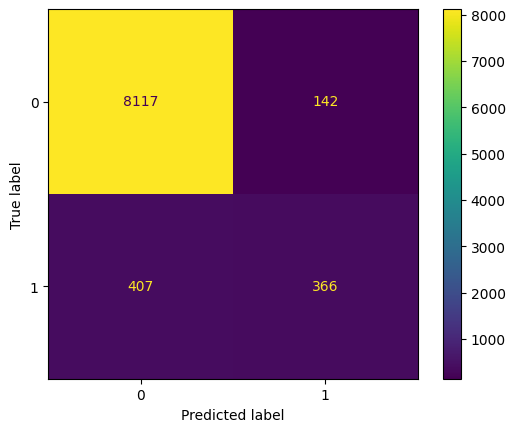

In [147]:
y_pred_rf = forestSKHP.predict(X_val)

conf_mat = confusion_matrix(y_val, y_pred_rf)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)

In [148]:
from sklearn.metrics import roc_curve
y_pred_rf_prob = forestSKHP.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold_rf = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (threshold_rf, gmeans[ix]))

Best Threshold=0.210000, G-Mean=0.850


In [149]:
rf_pred_new = pred_thresh(thresholds[ix], y_pred_rf_prob)

0.1539456662354463
0.928038047638493


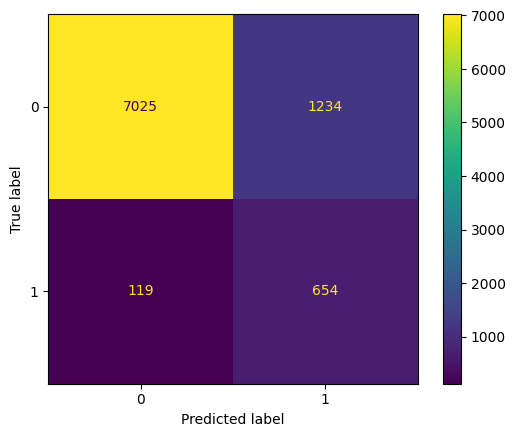

In [150]:

conf_mat = confusion_matrix(y_val, rf_pred_new)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)
print(roc_auc_score(y_val, y_pred_rf_prob))

SKlearn multi-layer percetrop implementation

In [62]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=1e-5, random_state=random_state)

parameters_nn = {'hidden_layer_sizes':[(10), (10, 10), (10, 10, 10)]}

clf_nn = GridSearchCV(mlp, parameters_nn)
clf_nn.fit(oversampled_X, oversampled_Y)


NameError: name 'GridSearchCV' is not defined

In [ ]:
clf_nn.best_estimator_

In [151]:
mlpHP = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 10, 10))
mlpHP.fit(oversampled_X, oversampled_Y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 10, 10))

In [76]:
cross_validation(mlpHP, X_train, y_train)

{'Training Accuracy scores': array([0.92837742, 0.9257651 , 0.92425999, 0.92732211, 0.92548959]),
 'Mean Training Accuracy': 92.62428403730412,
 'Training AUC scores': array([0.88851382, 0.87924685, 0.87602816, 0.88304848, 0.88184776]),
 'Mean Training AUC score': 0.8817370148174044,
 'Validation Accuracy scores': array([0.92588748, 0.92595668, 0.9237423 , 0.92706387, 0.92442907]),
 'Mean Validation Accuracy': 92.54158802721713,
 'Validation AUC Scores': array([0.88009726, 0.8762785 , 0.88152792, 0.87604916, 0.87397982]),
 'Mean Validation AUC score': 0.8775865326667354,
 'Validation f1 Scores': array([0.41698421, 0.3577431 , 0.24623803, 0.36429433, 0.30534351]),
 'Mean Validation f1 score': 0.3381206365390265,
 'Validation recall Scores': array([0.30887097, 0.24032258, 0.14516129, 0.24354839, 0.19354839]),
 'Mean Validation recall score': 0.22629032258064513}

0.1500646830530401


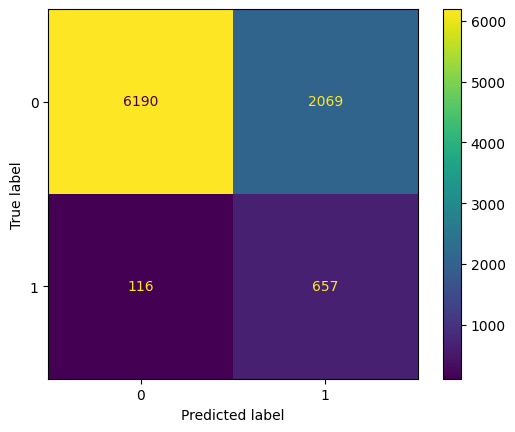

In [152]:
y_pred_nn = mlpHP.predict(X_val)

conf_mat = confusion_matrix(y_val, y_pred_nn)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)

In [153]:
from sklearn.metrics import roc_curve
y_pred_mlp_prob = mlpHP.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_mlp_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold_mlp = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (threshold_mlp, gmeans[ix]))

Best Threshold=0.565077, G-Mean=0.806


In [154]:
mlp_pred_new = pred_thresh(thresholds[ix], y_pred_mlp_prob)

0.17464424320827943
0.8799034868386941


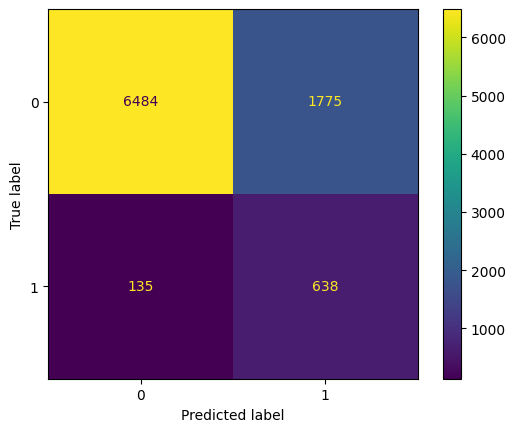

In [155]:

conf_mat = confusion_matrix(y_val, mlp_pred_new)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)
print(roc_auc_score(y_val, y_pred_mlp_prob))

IndexError: list index out of range

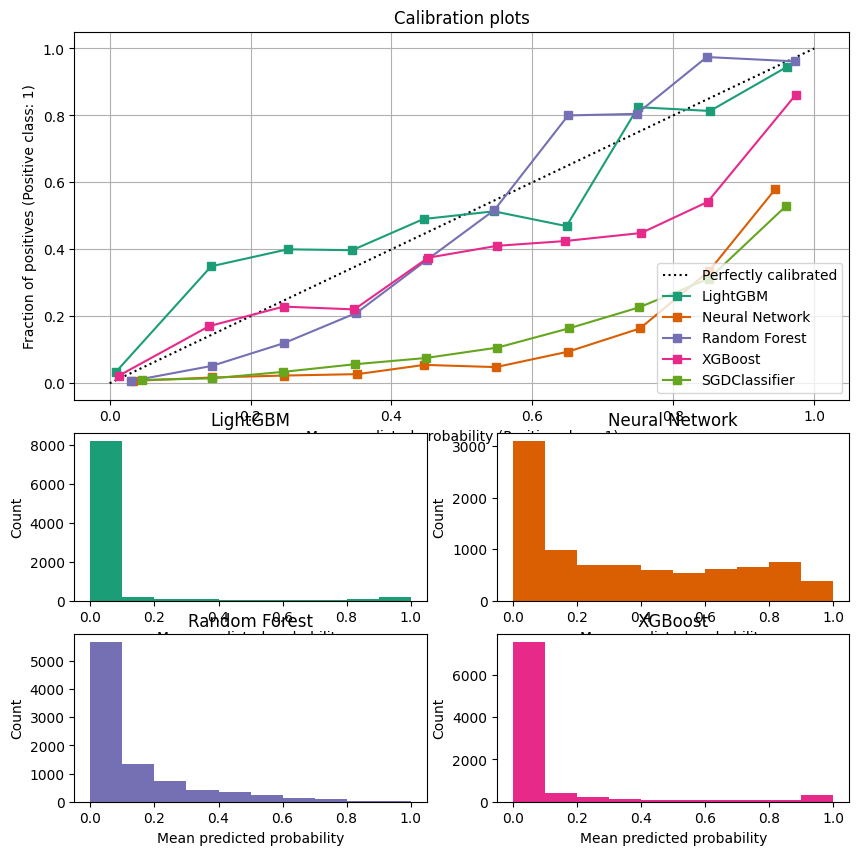

In [99]:
#taken from https://scikit-learn.org/stable/modules/calibration.html

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

clf_list = [
    (modelLightHP, "LightGBM"),
    (mlpHP, "Neural Network"), 
    (forestSKHP, "Random Forest"),
    (xgbHP, "XGBoost"), 
    (sgdclf, "SGDClassifier")
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(oversampled_X, oversampled_Y)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


<H2>Calibration of the models using CalibratedClassifierCV (Unfinished)</H2>

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV

# modelLightCal = CalibratedClassifierCV(modelLightHP)
# modelLightCal.fit(oversampled_X, oversampled_Y)


In [ ]:
# cross_validation(modelLightCal, oversampled_X, oversampled_Y)

In [ ]:
# y_pred_lgb = modelLightCal.predict(X_val)

# conf_mat = confusion_matrix(y_val, y_pred_lgb)

# disp = ConfusionMatrixDisplay(conf_mat)
# disp.plot()
# fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
# print(fnr)

In [ ]:


# clf_list = [
#     (modelLightCal, "LightGBM")
# ]

# fig = plt.figure(figsize=(10, 10))
# gs = GridSpec(4, 2)
# colors = plt.cm.get_cmap("Dark2")

# ax_calibration_curve = fig.add_subplot(gs[:2, :2])
# calibration_displays = {}
# for i, (clf, name) in enumerate(clf_list):
#     clf.fit(oversampled_X, oversampled_Y)
#     display = CalibrationDisplay.from_estimator(
#         clf,
#         X_val,
#         y_val,
#         n_bins=10,
#         name=name,
#         ax=ax_calibration_curve,
#         color=colors(i),
#     )
#     calibration_displays[name] = display

# ax_calibration_curve.grid()
# ax_calibration_curve.set_title("Calibration plot of LightGBM Calibrated")

# # Add histogram
# grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
#     row, col = grid_positions[i]
#     ax = fig.add_subplot(gs[row, col])

#     ax.hist(
#         calibration_displays[name].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(i),
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# plt.tight_layout()
# plt.show()


In [ ]:
# forestSKCal = CalibratedClassifierCV(forestSKHP)
# forestSKCal.fit(oversampled_X, oversampled_Y)


In [ ]:
# cross_validation(forestSKCal, oversampled_X, oversampled_Y)

In [ ]:
# y_pred_rf = forestSKCal.predict(X_val)

# conf_mat = confusion_matrix(y_val, y_pred_rf)

# disp = ConfusionMatrixDisplay(conf_mat)
# disp.plot()
# fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
# print(fnr)

In [ ]:

# clf_list = [
#     (forestSKCal, "Random Forest"),
# ]

# fig = plt.figure(figsize=(10, 10))
# gs = GridSpec(4, 2)
# colors = plt.cm.get_cmap("Dark2")

# ax_calibration_curve = fig.add_subplot(gs[:2, :2])
# calibration_displays = {}
# for i, (clf, name) in enumerate(clf_list):
#     clf.fit(oversampled_X, oversampled_Y)
#     display = CalibrationDisplay.from_estimator(
#         clf,
#         X_val,
#         y_val,
#         n_bins=10,
#         name=name,
#         ax=ax_calibration_curve,
#         color=colors(i),
#     )
#     calibration_displays[name] = display

# ax_calibration_curve.grid()
# ax_calibration_curve.set_title("Calibration plot of Calibrated Random Forest")

# # Add histogram
# grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
#     row, col = grid_positions[i]
#     ax = fig.add_subplot(gs[row, col])

#     ax.hist(
#         calibration_displays[name].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(i),
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# plt.tight_layout()
# plt.show()


In [ ]:
# #calibration XGboost
# xgb_cal = CalibratedClassifierCV(xgbHP)
# xgb_cal.fit(oversampled_X, oversampled_Y)

In [ ]:
# cross_validation(xgb_cal, oversampled_X, oversampled_Y)

In [ ]:
# y_pred_xgb = xgb_cal.predict(X_val)

# conf_mat = confusion_matrix(y_val, y_pred_xgb)

# disp = ConfusionMatrixDisplay(conf_mat)
# disp.plot()
# fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
# print(fnr)

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# clf_list = [
#     (xgb_cal, "XGBoost Calibrated"),
# ]

# fig = plt.figure(figsize=(10, 10))
# gs = GridSpec(4, 2)
# colors = plt.cm.get_cmap("Dark2")

# ax_calibration_curve = fig.add_subplot(gs[:2, :2])
# calibration_displays = {}
# for i, (clf, name) in enumerate(clf_list):
#     clf.fit(oversampled_X, oversampled_Y)
#     display = CalibrationDisplay.from_estimator(
#         clf,
#         X_val,
#         y_val,
#         n_bins=10,
#         name=name,
#         ax=ax_calibration_curve,
#         color=colors(i),
#     )
#     calibration_displays[name] = display

# ax_calibration_curve.grid()
# ax_calibration_curve.set_title("Calibration plots")

# # Add histogram
# grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
#     row, col = grid_positions[i]
#     ax = fig.add_subplot(gs[row, col])

#     ax.hist(
#         calibration_displays[name].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(i),
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# plt.tight_layout()
# plt.show()


In [ ]:
# #calibration nn
# mlpCal = CalibratedClassifierCV(mlpHP)
# mlpCal.fit(oversampled_X, oversampled_Y)

In [ ]:
# cross_validation(xgb_cal, oversampled_X, oversampled_Y)

In [ ]:
# y_pred_xgb = xgb_cal.predict(X_val)

# conf_mat = confusion_matrix(y_val, y_pred_xgb)

# disp = ConfusionMatrixDisplay(conf_mat)
# disp.plot()
# fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
# print(fnr)

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# clf_list = [
#     (mlpCal, "MLP Calibrated"),
# ]

# fig = plt.figure(figsize=(10, 10))
# gs = GridSpec(4, 2)
# colors = plt.cm.get_cmap("Dark2")

# ax_calibration_curve = fig.add_subplot(gs[:2, :2])
# calibration_displays = {}
# for i, (clf, name) in enumerate(clf_list):
#     clf.fit(oversampled_X, oversampled_Y)
#     display = CalibrationDisplay.from_estimator(
#         clf,
#         X_val,
#         y_val,
#         n_bins=10,
#         name=name,
#         ax=ax_calibration_curve,
#         color=colors(i),
#     )
#     calibration_displays[name] = display

# ax_calibration_curve.grid()
# ax_calibration_curve.set_title("Calibration plots")

# # Add histogram
# grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
#     row, col = grid_positions[i]
#     ax = fig.add_subplot(gs[row, col])

#     ax.hist(
#         calibration_displays[name].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(i),
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# plt.tight_layout()
# plt.show()


<H2>Evaluation</H2>

Testing auc on test set

In [181]:
y_pred_test_prob = forestSKHP.predict_proba(X_test)
y_pred_test = pred_thresh(threshold_rf, y_pred_test_prob[:,1])

In [182]:
roc_auc_score(y_test, y_pred_test_prob[:,1])

0.9317859259405049

0.12305854241338113


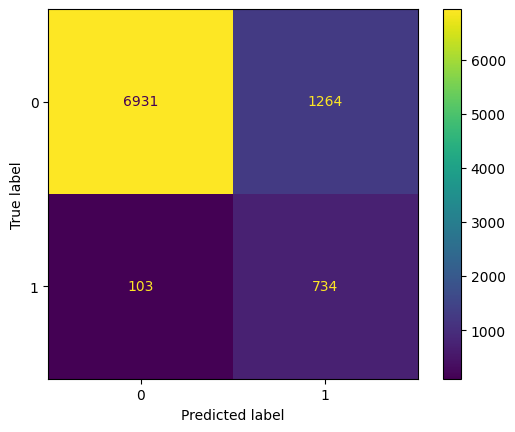

In [183]:
conf_mat = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
fnr = conf_mat[1,0]/(conf_mat[1,0]+conf_mat[1,1])
print(fnr)


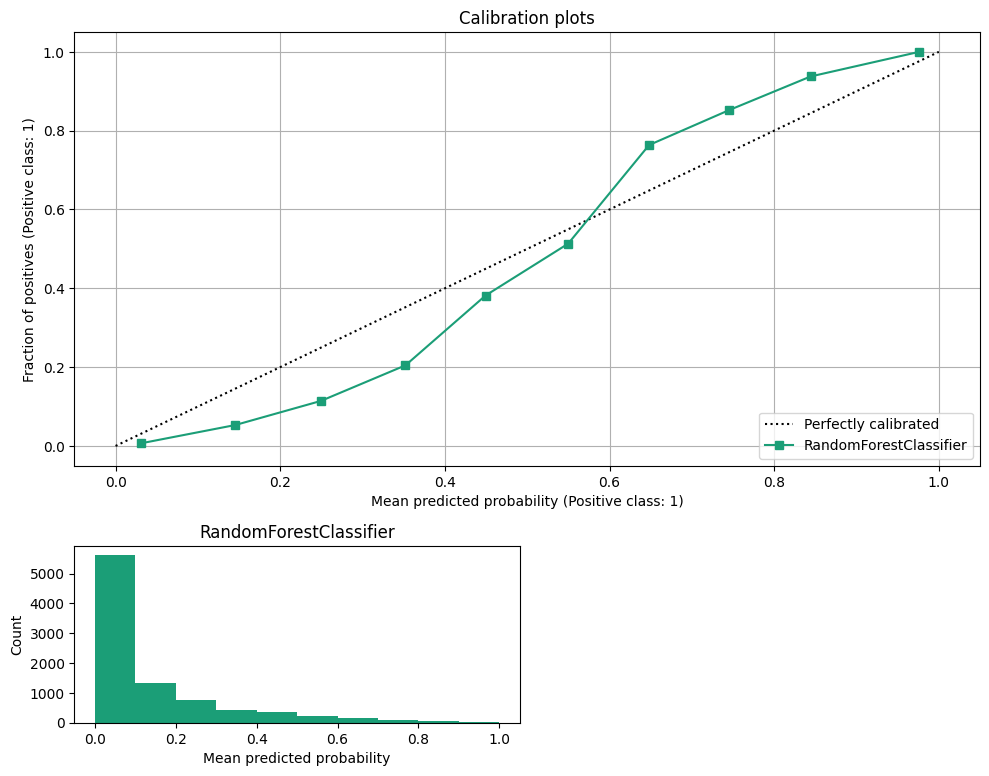

In [186]:
#taken from https://scikit-learn.org/stable/modules/calibration.html

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

clf_list = [
    (forestSKHP, "RandomForestClassifier")
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(oversampled_X, oversampled_Y)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'True Positive Rate')

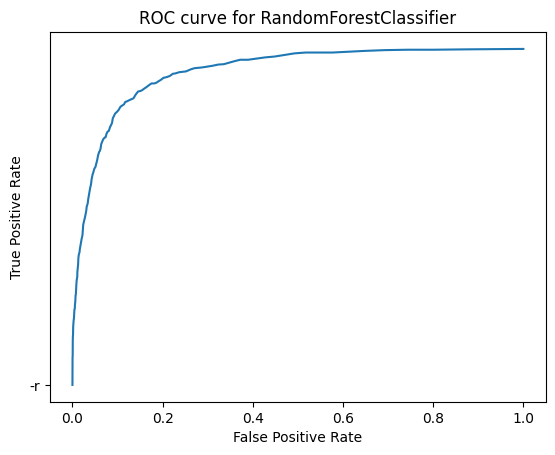

In [219]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:,1])

plt.plot(fpr, tpr, label="RFClassifier")
plt.plot([0, 0], [1, 1], '-', '-r')
plt.title("ROC curve for RandomForestClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [198]:
X_test.columns.values.tolist()

['num__age',
 'num__elective_surgery',
 'num__height',
 'num__pre_icu_los_days',
 'num__weight',
 'num__albumin_apache',
 'num__apache_2_diagnosis',
 'num__apache_3j_diagnosis',
 'num__apache_post_operative',
 'num__arf_apache',
 'num__bilirubin_apache',
 'num__bun_apache',
 'num__creatinine_apache',
 'num__fio2_apache',
 'num__gcs_eyes_apache',
 'num__gcs_motor_apache',
 'num__gcs_unable_apache',
 'num__gcs_verbal_apache',
 'num__glucose_apache',
 'num__heart_rate_apache',
 'num__hematocrit_apache',
 'num__intubated_apache',
 'num__map_apache',
 'num__paco2_apache',
 'num__paco2_for_ph_apache',
 'num__pao2_apache',
 'num__ph_apache',
 'num__resprate_apache',
 'num__sodium_apache',
 'num__temp_apache',
 'num__urineoutput_apache',
 'num__ventilated_apache',
 'num__wbc_apache',
 'num__d1_diasbp_invasive_max',
 'num__d1_diasbp_invasive_min',
 'num__d1_diasbp_max',
 'num__d1_diasbp_min',
 'num__d1_diasbp_noninvasive_max',
 'num__d1_diasbp_noninvasive_min',
 'num__d1_heartrate_max',
 'num__